# BLAES Units Parameter Analyses

This notebook contains code for determining whether the stimulation parameters used affect the proportion of modulated units. The single unit analyses include data from multiple versions of the BLAES experiment; the FreqStim task evaluated different gamma frequencies (33 Hz, 50 Hz, 80 Hz) and applied a lower stimulation amperage (0.5 mA vs. 1.0 mA).

---

> *Contact: Justin Campbell (justin.campbell@hsc.utah.edu)*  
> *Version: 05/03/2024*

## 1. Import Libraries

In [1]:
import os
import re
import glob
import datetime
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, ranksums, norm, fisher_exact, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format='svg'

## 2. Load Data

In [2]:
export = True

In [3]:
# Define paths
proj_path = '/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/'
results_path = os.path.join(proj_path, 'Results')

# Load stats summary
stats_df = pd.read_csv(os.path.join(results_path, 'Group', 'SpikeStats.csv'), index_col = 0)
stats_df_valid = stats_df[stats_df['Valid'] == 1] # get only valid units

# Get list of patients with processed data (included in analyses)
pIDs = stats_df['pID'].unique()

# Load stim parameter summary
stim_summary = pd.read_csv(proj_path + 'BLAESUnits Stim.csv')
stim_summary = stim_summary[stim_summary['pID'].isin(pIDs)]
stim_summary = stim_summary.reset_index(drop=True)

In [4]:
# Get the counts of significant and not significant units for each patient
sig_counts = {}
not_sig_counts = {}

for pID in pIDs:    
    # parse stats_df_valid for pID
    pID_stats = stats_df_valid[stats_df_valid['pID'] == pID]
    sig_counts[pID] = pID_stats['StimSig'].sum()
    not_sig_counts[pID] = pID_stats['StimSig'].count() - pID_stats['StimSig'].sum()
    
not_sig_counts    

sig_counts = pd.Series(sig_counts)
not_sig_counts = pd.Series(not_sig_counts)

# # Construct DataFrame
sig_counts_df = pd.DataFrame({'Sig': sig_counts, 'Not Sig': not_sig_counts})
sig_counts_df['Total'] = sig_counts_df['Sig'] + sig_counts_df['Not Sig']
sig_counts_df['Prop'] = sig_counts_df['Sig'] / sig_counts_df['Total'] * 100
sig_counts_df['pID'] = sig_counts_df.index
sig_counts_df = sig_counts_df[['pID', 'Sig', 'Not Sig', 'Total', 'Prop']]
sig_counts_df = sig_counts_df[sig_counts_df['Total'] > 0]
sig_counts_df = sig_counts_df.reset_index(drop=True)

## 3. Summarize Different Parameters
Display the amperage (mA), gamma-frequency (Hz), and pulse-width (us) used across experiments. These parameters were varied across different experiment types (e.g., objects vs. scenes, frequency-modulation, parameter sweep).

In [5]:
print(stim_summary['mA'].value_counts().to_string())
print('')

print(stim_summary['GammaFreq'].value_counts().to_string())
print('')

print(stim_summary['PW'].value_counts().to_string())

mA
1      23
0.5     7

GammaFreq
50        23
50, 80     6
33, 80     1

PW
250    30


## 4. Test for Association Between Amperage & Modulation (% Sig)
This code block uses a Fisher's exact test to compare the proportion of units modulated between the 0.5 mA and the 1 mA experiments.

In [6]:
n_sessions_05 = stim_summary[stim_summary['mA'] == '0.5']['pID'].nunique()
n_sessions_1 = stim_summary[stim_summary['mA'] == '1']['pID'].nunique()

/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_2682/4115087351.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot([props_05, props_1], palette = plotPal, saturation = 0.9)
/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_2682/4115087351.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0.5', '1'])


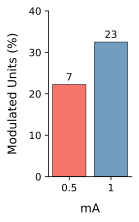

1mA vs. 0.5mA
OR = 1.69, (p = 0.302)


In [7]:
# Add mA information
sig_counts_df['mA'] = sig_counts_df['pID'].map(stim_summary.set_index('pID')['mA'])

# Create contingency tables
mA_05 = sig_counts_df[sig_counts_df['mA'] == '0.5'][['Sig', 'Not Sig']].sum()
mA_1 = sig_counts_df[sig_counts_df['mA'] == '1'][['Sig', 'Not Sig']].sum()

# Perform Chi-squared test
fisher_table = np.array([mA_1.values, mA_05.values])
odds_ratio, p_value = fisher_exact(fisher_table)

# Organize data
sig_cnt_05 = sig_counts_df[sig_counts_df['mA'] == '0.5']['Sig'].sum()
sig_cnt_1 = sig_counts_df[sig_counts_df['mA'] == '1']['Sig'].sum()
props_05 = 100 * sig_cnt_05 / sig_counts_df[sig_counts_df['mA'] == '0.5']['Total'].sum()
props_1 = 100 * sig_cnt_1 / sig_counts_df[sig_counts_df['mA'] == '1']['Total'].sum()

# Plot
fig, ax = plt.subplots(1, 1, figsize = (1.5, 3))
plotPal = ['#ff6e61', '#6d9dc5']
sns.barplot([props_05, props_1], palette = plotPal, saturation = 0.9)

# Figure aesthetics
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
ax.set_xticklabels(['0.5', '1'])
plt.xlabel('mA', fontsize = 'large', labelpad = 10)
ax.set_yticks(np.arange(0, 50, 10))
plt.ylabel('Modulated Units (%)', fontsize = 'large', labelpad = 10)
sns.despine(top = True, right = True)

# Add sample size above each bar
y_pos = [props_05,props_1]
for i, p in enumerate([n_sessions_05, n_sessions_1]):
    ax.text(i, y_pos[i]+1, str(p), color = 'black', ha = 'center')

# Export & Display
if export:
    plt.savefig((os.path.join(results_path, 'Group', 'Figures', 'ParamsAmpSig.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()
print('1mA vs. 0.5mA')
print('OR = %.2f, (p = %.3f)' % (odds_ratio, p_value))

## 5. Parse Separate Gamma-Frequency Trials

In [8]:
def runFRContrast(spike_info):
    '''
    This function runs a Wilcoxon signed-rank test on the firing rates of each unit in the Pre- vs. Post-stim epochs and the Pre- vs. During-stim epochs. It also runs permutation testing to determine whether the observed test statistic is in the 5% of most extreme values in the permutation distribution (p < 0.05).
    
    Inputs:
    - spike_info (DataFrame): 
    
    Outputs:
    - statsDF (DataFrame): A DataFrame with the results of the statistical tests.
    '''

    # Holders for dataframe
    statsPrePost = []
    statsPreDuring = []
    pValsPrePost = []
    pValsPreDuring = []
    pValsPrePostPerm = []
    pValsPreDuringPerm = []
    resultsPrePostPerm = []
    resultsPreDuringPerm = []
    permHolderPrePost = []
    permHolderPreDuring = []
    unitLabels = []
    pIDLabels = []
    validity = []
    preFRs = []
    duringFRs = []
    postFRs = []
    gammaFreqs = []
    
    # Get info
    pID = spike_info['pID'].iloc[0]
    unit = spike_info['Unit'].iloc[0]


    # Run stats on valid units
    if spike_info['Valid'].iloc[0] == True:
        try:
            statPrePost, pPrePost = wilcoxon(spike_info['Post'], spike_info['ISI'])
        except:
            statPrePost = np.nan
            pPrePost = np.nan
        try:
            statPreDuring, pPreDuring = wilcoxon(spike_info['During'], spike_info['ISI'])
        except:
            statPreDuring = np.nan
            pPreDuring = np.nan

        # Permutation testing
        permStatsPrePost = []
        permStatsPreDuring = []
        nPerms = 1000
        np.random.seed(0)
        
        # Pre- vs. Post-stim
        for i in range(nPerms):
            permDF = spike_info[['ISI', 'Post']].copy().melt(var_name = 'Epoch', value_name = 'Spike')
            epochLabels = permDF['Epoch']
            epochLabels = np.random.permutation(epochLabels)
            permDF['Epoch'] = epochLabels
            preSpikes = permDF[permDF['Epoch'] == 'ISI']['Spike']
            postSpikes = permDF[permDF['Epoch'] == 'Post']['Spike']
            
            permStatPrePost, _ = wilcoxon(postSpikes.values, preSpikes.values)
            permStatsPrePost.append(permStatPrePost)
        permHolderPrePost.append(permStatsPrePost)
        
        # Pre- vs. During-stim
        for i in range(nPerms):
            permDF = spike_info[['ISI', 'During']].copy().melt(var_name = 'Epoch', value_name = 'Spike')
            epochLabels = permDF['Epoch']
            epochLabels = np.random.permutation(epochLabels)
            permDF['Epoch'] = epochLabels
            preSpikes = permDF[permDF['Epoch'] == 'ISI']['Spike']
            duringSpikes = permDF[permDF['Epoch'] == 'During']['Spike']
            
            permStatPreDuring, _ = wilcoxon(duringSpikes.values, preSpikes.values)
            permStatsPreDuring.append(permStatPreDuring)
        permHolderPreDuring.append(permStatsPreDuring)
            
        # Compute p-values using z-score method(from permutation distribution)
        zPrePostPerm = (statPrePost - np.mean(permStatsPrePost)) / np.std(permStatsPrePost)
        pPrePostPerm = norm.sf(abs(zPrePostPerm)) * 2
        if pPrePostPerm < 0.05:
            resultsPrePostPerm.append(True)
        else:
            resultsPrePostPerm.append(False)
            
        zPreDuringPerm = (statPreDuring - np.mean(permStatsPreDuring)) / np.std(permStatsPreDuring)
        pPreDuringPerm = norm.sf(abs(zPreDuringPerm)) * 2
        if pPreDuringPerm < 0.05:
            resultsPreDuringPerm.append(True)
        else:
            resultsPreDuringPerm.append(False)
        
    # If unit is invalid
    else:
        statPrePost = np.nan
        statPreDuring = np.nan
        pPrePost = np.nan
        pPreDuring = np.nan
        pPrePostPerm = np.nan
        pPreDuringPerm = np.nan
        resultsPrePostPerm.append(np.nan)
        resultsPreDuringPerm.append(np.nan)
        permHolderPrePost.append(np.nan)
        permHolderPreDuring.append(np.nan)
        gammaFreqs.append(np.nan)
    
    # Append to holders
    statsPrePost.append(statPrePost)
    statsPreDuring.append(statPreDuring)
    pValsPrePost.append(pPrePost)
    pValsPreDuring.append(pPreDuring)
    pValsPrePostPerm.append(pPrePostPerm)
    pValsPreDuringPerm.append(pPreDuringPerm)
    unitLabels.append(unit)
    pIDLabels.append(pID)
    validity.append(spike_info['Valid'].iloc[0])
    preFRs.append(spike_info['Pre'].mean())
    duringFRs.append(spike_info['During'].mean())
    postFRs.append(spike_info['Post'].mean())
    gammaFreqs.append(spike_info['Gamma'].iloc[0])
    
    # Construct dataframe
    statsDF = pd.DataFrame({'pID': pIDLabels, 'Unit': unitLabels, 'Valid': validity, 'Pre': preFRs, 'During': duringFRs, 'Post': postFRs, 'Stat_PrePost': statsPrePost, 'Stat_PreDuring': statsPreDuring, 'pVal_PrePost': pValsPrePost, 'pVal_PreDuring': pValsPreDuring, 'pVal_PrePost_Perm': pValsPrePostPerm, 'pVal_PreDuring_Perm': pValsPreDuringPerm, 'PermSig_PrePost': resultsPrePostPerm, 'PermSig_PreDuring': resultsPreDuringPerm,'PermStats_PrePost': permHolderPrePost, 'PermStats_PreDuring': permHolderPreDuring})

    # Add column for significant results w/ permutation testing
    statsDF['Sig'] = (statsDF['PermSig_PrePost'] == True) | (statsDF['PermSig_PreDuring'] == True)
        
    return statsDF

In [9]:
# Get sessions from freq stim experiment
df_freqstim = stim_summary[stim_summary['Experiment'] == 'Freq Stim']
df_freqstim = df_freqstim.reset_index(drop=True)
df_freqstim

,pID,Source,Age,Sex,Cathode,Anode,Laterality,mA,GammaFreq,PW,Experiment,NoStim d',Stim d',FA,Leads,Included,PD,Comments
0,UIC20231401,Utah,42.0,F,bRAMY1,bRAMY2,R,0.5,"50, 80",250,Freq Stim,1.88,1.740,0.200,3.0,1,1.0,NaN
1,UIC20240101,Utah,40.0,F,bRAMY1,bRAMY2,R,0.5,"50, 80",250,Freq Stim,2.45,2.300,0.000,3.0,1,1.0,NaN
2,BJH04001,WashU,38.0,M,AL3,AL2,L,0.5,"50, 80",250,Freq Stim,1.92,2.170,0.025,2.0,1,NaN,NaN
3,BJH04201,WashU,41.0,M,AL1,AL2,L,0.5,"50, 80",250,Freq Stim,1.52,1.860,0.075,2.0,1,NaN,NaN
4,BJH04501,WashU,22.0,M,AR1,AR2,R,0.5,"50, 80",250,Freq Stim,1.75,1.810,0.050,2.0,1,NaN,NaN
5,BJH04502,WashU,22.0,M,AR1,AR2,R,0.5,"33, 80",250,Freq Stim,1.51,1.695,0.150,2.0,1,NaN,NaN
6,BJH04601,WashU,60.0,F,AL4,AL3,L,0.5,"50, 80",250,Freq Stim,2.13,2.345,0.100,1.0,1,NaN,NaN


In [10]:
# Stats holder
stats_holder = []

# Loop through all patients
for pID in df_freqstim['pID'].unique():

    # Load trial spike counts
    spike_counts = pd.read_csv(os.path.join(results_path, pID, 'TrialSpikeCounts.csv'), index_col = 0)

    # Loop through all units
    for unit in spike_counts['Unit'].unique():

        # Get spike counts for unit
        unit_spike_counts = spike_counts[spike_counts['Unit'] == unit]

        # Load trial info
        trial_info = pd.read_csv(os.path.join(proj_path, 'TrialInfo', pID + '_TrialInfo.csv'))

        # Remove rows with nan in Gamma (no-stim trials)
        trial_info = trial_info[~trial_info['Gamma'].isna()]
        trial_info['Gamma'] = trial_info['Gamma'].astype(int)

        # Get unique values of Gamma
        gamma_vals = trial_info['Gamma'].unique()

        # Find trials with each gamma value
        gamma_trials = {}
        for gamma in gamma_vals:
            gamma_trials[gamma] = trial_info[trial_info['Gamma'] == gamma]['Trial']
            
        # Get spike counts for each trial
        gamma_spike_counts = {}
        for gamma in gamma_vals:
            spike_holder = []
            for trial in gamma_trials[gamma]:
                spike_holder.append(unit_spike_counts[unit_spike_counts['Trial'] == trial])
            df = pd.concat(spike_holder)
            df = df.reset_index(drop=True)
            df['Gamma'] = gamma
            
            # recompute validity
            if df['ISI'].mean() >= 0.1:
                df['Valid'] = True
            else:
                df['Valid'] = False

            # run FR contrast
            statsDF = runFRContrast(df)
            statsDF['Gamma'] = gamma
            stats_holder.append(statsDF)
        
statsDF = pd.concat(stats_holder)

In [11]:
gamma_33 = []
gamma_50 = []
gamma_80 = []

for pID in statsDF['pID'].unique():
    pID_stats = statsDF[statsDF['pID'] == pID]
    
    gamma_33.append(pID_stats[pID_stats['Gamma'] == 33]['Sig'].mean())
    gamma_50.append(pID_stats[pID_stats['Gamma'] == 50]['Sig'].mean())
    gamma_80.append(pID_stats[pID_stats['Gamma'] == 80]['Sig'].mean())
    
gamma_33 = np.array(gamma_33)
gamma_50 = np.array(gamma_50)
gamma_80 = np.array(gamma_80)

# remove nans
gamma_33 = gamma_33[~np.isnan(gamma_33)]
gamma_50 = gamma_50[~np.isnan(gamma_50)]
gamma_80 = gamma_80[~np.isnan(gamma_80)]
    
# Create dataframe
gamma_df = pd.DataFrame({'Percent': np.concatenate([gamma_50, gamma_80]), 'Gamma': np.concatenate([np.repeat(50, len(gamma_50)), np.repeat(80, len(gamma_80))])})
gamma_df['Percent'] = gamma_df['Percent'] * 100

In [12]:
sig_counts_33 = []
notsig_counts_33 = []
sig_counts_50 = []
notsig_counts_50 = []
sig_counts_80 = []
notsig_counts_80 = []

for pID in statsDF['pID'].unique():
    for gamma in [33, 50, 80]:
        df = statsDF[(statsDF['pID'] == pID) & (statsDF['Gamma'] == gamma)]
        n_sig = df['Sig'].sum()
        n_not_sig = df['Sig'].count() - n_sig
        if gamma == 33:
            sig_counts_33.append(n_sig)
            notsig_counts_33.append(n_not_sig)
        elif gamma == 50:
            sig_counts_50.append(n_sig)
            notsig_counts_50.append(n_not_sig)
        else:
            sig_counts_80.append(n_sig)
            notsig_counts_80.append(n_not_sig)
    
total_sig_33 = np.sum(sig_counts_33)
props_sig_33 = 100 * total_sig_33 / np.sum(sig_counts_33 + notsig_counts_33)

total_sig_50 = np.sum(sig_counts_50)
props_sig_50 = 100 * total_sig_50 / np.sum(sig_counts_50 + notsig_counts_50)

total_sig_80 = np.sum(sig_counts_80)
props_sig_80 = 100 * total_sig_80 / np.sum(sig_counts_80 + notsig_counts_80)

In [13]:
n_sessions_33 = statsDF[statsDF['Gamma'] == 33]['pID'].nunique()
n_sessions_50 = statsDF[statsDF['Gamma'] == 50]['pID'].nunique()
n_sessions_80 = statsDF[statsDF['Gamma'] == 80]['pID'].nunique()

/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_2682/1949288570.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot([props_sig_33, props_sig_50, props_sig_80], palette = plotPal, saturation = 0.9)
/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_2682/1949288570.py:8: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot([props_sig_33, props_sig_50, props_sig_80], palette = plotPal, saturation = 0.9)
/var/folders/mq/6f6ky9r97r1_mqfg3vjq9fd00000gn/T/ipykernel_2682/1949288570.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['33', '50', '80'])


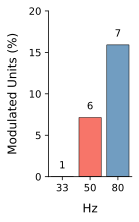

50Hz vs. 80Hz
OR = 2.46, (p = 0.315)


In [14]:
# Perform Chi-squared test
fisher_table = np.array([[total_sig_80, np.sum(notsig_counts_80)], [total_sig_50, np.sum(notsig_counts_50)]])
odds_ratio, p_value = fisher_exact(fisher_table)

# Plot
fig, ax = plt.subplots(1, 1, figsize = (1.5, 3))
plotPal = ['#6d9dc5', '#ff6e61']
sns.barplot([props_sig_33, props_sig_50, props_sig_80], palette = plotPal, saturation = 0.9)

# Figure aesthetics
plt.setp(ax.patches, linewidth = 0.5, edgecolor = 'k')
ax.set_xticklabels(['33', '50', '80'])
plt.xlabel('Hz', fontsize = 'large', labelpad = 10)
ax.set_yticks(np.arange(0, 21, 5))
plt.ylabel('Modulated Units (%)', fontsize = 'large', labelpad = 10)
sns.despine(top = True, right = True)

# Add sample size above each bar
y_pos = [props_sig_33, props_sig_50, props_sig_80]
for i, p in enumerate([n_sessions_33, n_sessions_50, n_sessions_80]):
    ax.text(i, y_pos[i]+1, str(p), color = 'black', ha = 'center')

# Export & Display
if export:
    plt.savefig((os.path.join(results_path, 'Group', 'Figures', 'ParamsGammaSig.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

print('50Hz vs. 80Hz')
print('OR = %.2f, (p = %.3f)' % (odds_ratio, p_value))